<a href="https://colab.research.google.com/github/Han-Archives/Colab/blob/main/%EC%9C%A0%ED%8A%9C%EB%B8%8C_%EB%8C%93%EA%B8%80_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 유튜브 댓글 분석하기




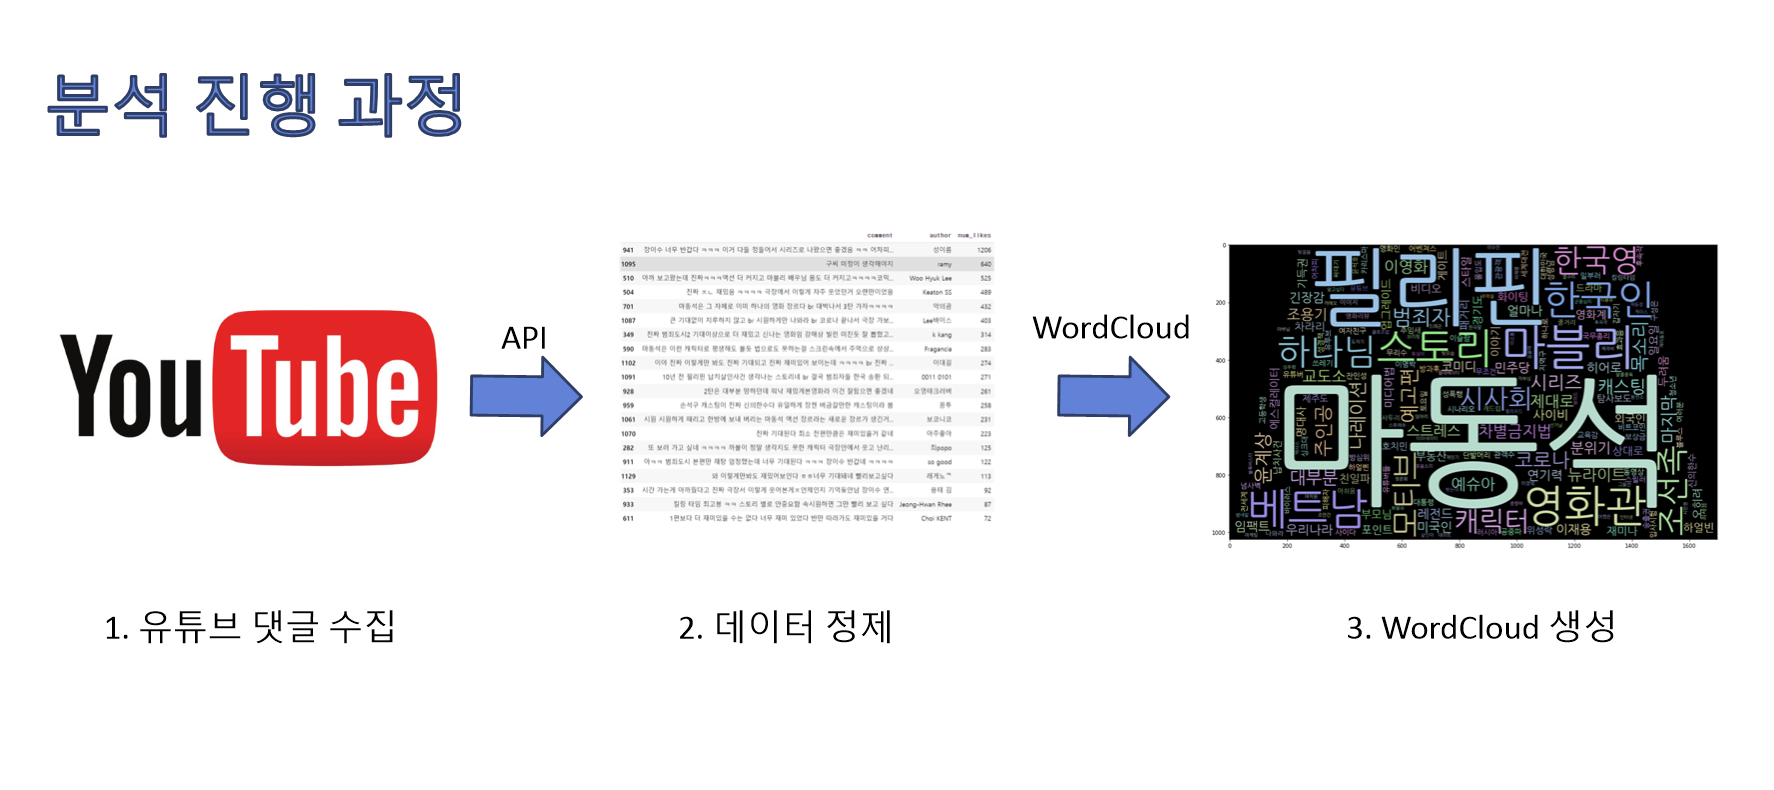

In [ ]:
pip install google-api-python-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 글꼴 설정
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕

Selecting previously unselected package fonts-nanum.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
### install modules
import re
from googleapiclient.discovery import build
from konlpy.tag import Okt
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
import numpy as np
import pandas as pd

import warnings # 경고창 무시
warnings.filterwarnings('ignore')

## 유튜브 댓글 수집하기

In [ ]:
links = input("유튜브 링크 전체 주소를 입력해주세요. \n ex) https://www.youtube.com/watch?v=xx-xxxxxxxxx \n\n")

if len(links) > 47 or len(links) < 41:
  print("다시 입력해주시기 바랍니다.")

else:
  video_id = links.replace("https://www.youtube.com/watch?v=", "")


유튜브 링크 전체 주소를 입력해주세요. 
 ex) https://www.youtube.com/watch?v=xx-xxxxxxxxx 

https://www.youtube.com/watch?v=ET_UJZWuY-o


In [ ]:
## 아래 코드에서 주로 사용되는 변수 -- 개인 정보 포함되어 있으므로 추후 배포시 수정요망
api_key = 'API 키' # 구글 API 키
comment_num = 400 # 댓글 갯수

In [ ]:
# 댓글을 저장할 리스트
comments = list()
# developerKey = API 키
api_obj = build('youtube', 'v3', developerKey=api_key)

# videoId는 각 유튜브 영상 url의 watch?v 뒤의 값을 사용
response = api_obj.commentThreads().list(part='snippet', videoId=video_id, maxResults=comment_num).execute()

In [ ]:
# 댓글, 댓글작성자, 좋아요 수
while response:
    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([comment['textDisplay'], comment['authorDisplayName'], comment['likeCount']])
 
 # 다음 페이지가 있는 경우 재호출
    if 'nextPageToken' in response:
        response = api_obj.commentThreads().list(part='snippet', videoId=video_id, pageToken=response['nextPageToken'], maxResults=comment_num).execute()
    else:
        break

In [ ]:
df = pd.DataFrame(comments, columns=['comment','author','num_likes'], index=None)

## 수집한 데이터 정제하기

In [ ]:
# 특수문자 제거하기
df['comment'] = df['comment'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

# 특정문자 제거하기
df['comment'] = df['comment'].str.replace(pat=r'br', repl=r' ', regex=True)
df['comment'] = df['comment'].str.replace(pat=r'quot', repl=r' ', regex=True)
df['comment']

0        태양의 후예 풀버젼 전 회차 다시보기      href  https   www y...
1       난 이분 리뷰가 아니면 드라마던 영화던 보기가 싫지말입니다 ㅋ 대단하신분     적...
2        OST 영향력이 대단해서 당시 노래방 가면 옆방에서 OST 들릴 확률 5만 8천 퍼센트
3                           송혜교보다 저기 얼굴 뽀얀 간호사가 훨씬 더 예쁘더라
4                                         여주 캐릭터 발암이라 하차함
                              ...                        
1137                                     와 이거 초딩때 개재밌게봤는데
1138                                                    2
1139                                                  1드 
1140                                                     
1141                                                    1
Name: comment, Length: 1142, dtype: object

### 좋아요를 많이 받은 글 top 20

In [ ]:
# 좋아요를 많이 받은 글 top 20
likes = df.sort_values(by='num_likes', ascending=False)
likes.head(20)

,comment,author,num_likes
992,방영 당시 군사학과 지원률을 어마무시하게 올린 대작 ㅜ 봐도봐도 질리지 않...,moca302,1668
686,방영 시기에 현역 군인이였는데 이 드라마 방영 이후로 군인들 휴가 나가면 외국인들이...,어쩔필름,1429
1038,똥먹어본사람 개추 ㅋㅋ,문찬,965
464,현실성은 정말 거의 없었지만 작품성 스토리 대중성 심지어 재미까지 진짜 단연...,김민주,817
909,10번 넘게 돌려봐도 질리지 않는 드라마 G무비님이 리뷰해주시니 한번 더 보게...,준영 박,743
714,성공이유 1 그 시절 드라마에는 사용되지 않았던 군인 의 배경 그것...,이지은,507
1019,지무비님 감사합니다 태양의 후예 전체회차 바로보기 1회는 무료입니...,KBS Drama Classic,454
1092,진짜 한때 태후 열풍이 일어났을 때가 엊그제 같은데 벌써 6년이란 시간이 흘렀네 ...,지존최강 달소💙,454
1118,진짜 추억의 드라마다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,music senpai,239
615,이 드라마 나왔을때 초딩이었는데 학교가면 홍보 포스터도 군인 유행말투로 되어있고 ...,노을,209


In [ ]:
# 불필요한 단어 제거하기
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','br','a','href','https','www','youtube','com','watch','v']

In [ ]:
# 토큰화 하면서 불용어 제거하기
okt = Okt()

comment_token = []

for comment in tqdm(df['comment']):
    tokenized_comment = okt.nouns(comment) # 명사만 토큰화
    stopwords_removed_comment = [word for word in tokenized_comment if not word in stopwords] # 불용어 제거
    comment_token.append(stopwords_removed_comment)

100%|██████████| 1142/1142 [00:06<00:00, 171.40it/s]


In [ ]:
# 리스트 평탄화
words = sum(comment_token, [])
t_words = [n for n in words if len(n) > 2] # 단어의 길이가 1개인 것은 제외

c = Counter(t_words)

In [ ]:
# 색깔 보정
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(30,313),np.random.randint(26,62),np.random.randint(65,80)))

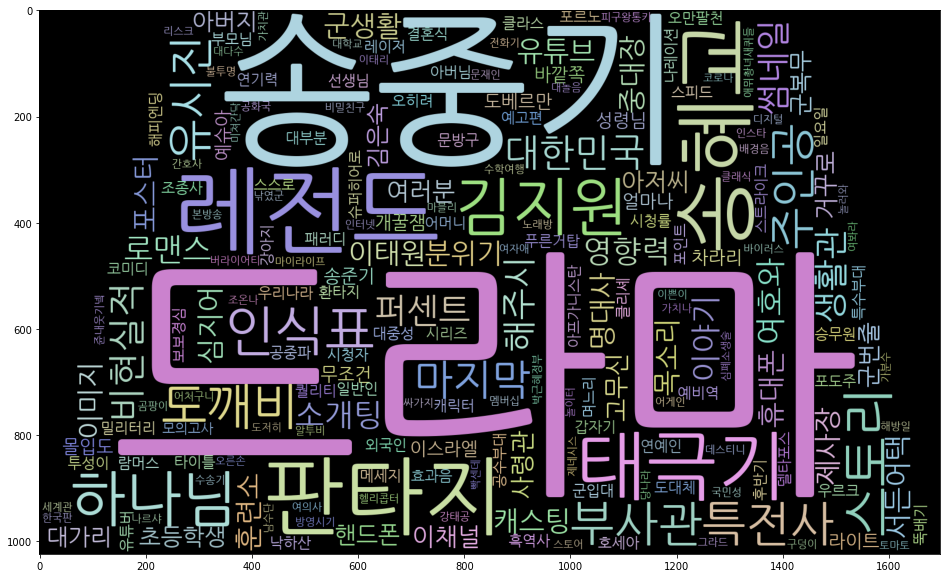

In [ ]:
# img는 wordcloud의 모양 형태에 쓰임
img = Image.open('pic2.jpg')
img_array = np.array(img)

wc = WordCloud(font_path=path, width=400, height=400, scale=2.0, max_font_size=250, background_color='black',color_func = color_func, mask=img_array)
gen = wc.generate_from_frequencies(c)
plt.figure(figsize=(20,10))
plt.imshow(gen)

In [ ]:
## save
likes.to_csv("result.csv", index=None)


## Reference

https://han-py.tistory.com/432

https://doitgrow.com/34

https://wannabe00.tistory.com/entry/Word-cloud-%EC%9B%90%ED%95%98%EB%8A%94-%EC%83%89%EC%9C%BC%EB%A1%9C-%EA%BE%B8%EB%AF%B8%EA%B8%B0-word-cloud-customize-color